In [1]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage

seed = np.random.seed()

In [2]:
# Read in Data
with open('data/sem_items_new.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_relations_new.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_attributes_new.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])

In [3]:
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print('List of items:')
print(*names_items,sep=',')
print("\nList of relations:")
print(*names_relations,sep=',')
print("\nList of attributes:")
print(*names_attributes,sep=',')

List of items:
Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile

List of relations:
ISA,Is,Can,Has

List of attributes:
Living thing,Plant,Animal,Tree,Flower,Bird,Fish,Reptile,Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile,Pretty,Big,Living,Green,Red,Yellow,Slow,Grow,Move,Swim,Fly,Sing,Skin,Roots,Leaves,Bark,Branch,Petals,Wings,Feathers,Gills,Scales,Backbone,Produce Eggs,Shell


In [125]:
item_display_ind = 35 # can change, just represents index of input data to show as example.

D = np.loadtxt('data/sem_data_new.txt')
input_pats = D[:,:nobj+nrel]
input_pats = torch.tensor(input_pats,dtype=torch.float)
output_pats = D[:,nobj+nrel:]
output_pats = torch.tensor(output_pats,dtype=torch.float)
N = input_pats.shape[0] # number of training patterns



input_v = input_pats[item_display_ind,:].numpy().astype('bool')
output_v = output_pats[item_display_ind,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:nobj]])
print('Relation ',end='')
print(names_relations[input_v[nobj:]])
print('Attributes ',end='')
print(names_attributes[output_v])

Example input pattern:
[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
Example output pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 1]

Which encodes...
Item ['Turtle']
Relation ['Has']
Attributes ['Skin' 'Backbone' 'Shell']


In [126]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        # TODO : YOUR CODE GOES HERE
        self.i2rep = nn.Linear(nobj,rep_size)
        self.all2h = nn.Linear(rep_size+nrel,hidden_size)
        self.h2o = nn.Linear(hidden_size,nattributes)
        self.sigmoid = torch.sigmoid

    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,nobj+nrel) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:nobj] # input to Item Layer [B x nobj Tensor]
        x_rel = x[:,nobj:] # input to Relation Layer [B x nrel Tensor]
        
        rep = self.i2rep(x_item)
        rep = relu(rep)
        to_hidden = torch.cat((rep,x_rel),1)
        hidden = self.all2h(to_hidden)
        hidden = relu(hidden)
        output = self.h2o(hidden)
        output = self.sigmoid(output)
        
        return output, hidden, rep

In [127]:
class EarlyStop() :
    
    def __init__(self,patience=10,epsilon=.0001) :
        
        self.allowed = 0
        self.patience = patience
        self.epsilon = epsilon
        self.early_stop = False
        self.state = {}
        self.min_loss = 9e10
        
    def step(self,loss,model) :
        
        if abs(loss - self.min_loss) < self.epsilon :
            print('Incremental Loss is less than epsilon value...')
            self.early_stop = True
        if loss > self.min_loss :
            self.min_loss += 1
        else :
            self.min_loss = loss
            self.w = model.state_dict()
            self.allowed = 0 # reset if the loss decreased an acceptable amount
            
        if self.allowed == self.patience :
            print('Loss has not decreased for {} epochs'.format(self.patience))
            self.early_stop = True
            

In [128]:
def train(mynet):
    # Input
    #  mynet : Net class object
    error_epoch = 0
    mynet.train()
    perm = np.random.permutation(N)
    for p in perm: # iterate through input patterns in random order
        mynet.zero_grad() # reset gradient
        output, hidden, rep = mynet(input_pats[p,:]) # forward pass
        target = output_pats[p,:] 
        target = target.view(1,-1) # Get target into expected [1,_] format
        loss = criterion(output, target) # compute loss
        loss.backward() # compute gradient 
        optimizer.step() # update network parameters
        error_epoch += loss.item()
    
    return error_epoch / float(N)

In [129]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    return mynet(torch.eye(nobj,nobj+nrel))[2].detach().numpy()

def plot_opt1(rep_layer) :
    
    stacked = np.dstack(rep_layer)
    fig,axes = plt.subplots(nrows=4,ncols=2,sharex=True,sharey=False,figsize=(15,10),squeeze=False)
    fig.suptitle('Representation Layer Weights per epoch',size=15)

    row_count,col_count = 0,0

    for j in range(8) :
        axes[row_count,col_count].set_title('Rep Node {}'.format(j))
        for i,name in enumerate(names_items) :
            axes[row_count,col_count].plot(range(n_epochs),stacked[i][j])
        if col_count == 1 :
            row_count+=1
            col_count = 0
        else :
            col_count += 1
    fig.legend(names_items,ncol=10,loc='lower center',fontsize=10)
    plt.show()

def plot_opt2(rep_layer) :
    
    stacked = np.dstack(rep_layer)
    fig,axes = plt.subplots(nrows=5,ncols=2,sharex=True,sharey=False,figsize=(15,10),squeeze=False)
    fig.suptitle('Representation Layer Weights per epoch',size=15)

    row_count,col_count = 0,0

    for i,name in enumerate(names_items) :
        axes[row_count,col_count].set_title(name)
        for j in range(8) :
            axes[row_count,col_count].plot(range(n_epochs),stacked[i][j])
        if col_count == 1 :
            row_count+=1
            col_count = 0
        else :
            col_count += 1
    fig.legend(['Rep_Node_'+str(i) for i in range(8)],ncol=10,loc='lower center',fontsize=10)
    plt.show()

def plot_opt3(rep_layer,num_plots=3):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    epochs_plot = [i if i < len(rep_layer) else i-1 for 
                   i in list(map(int,np.linspace(0,len(rep_layer),num_plots)))]
    stacked = np.dstack(rep_layer)    
    mx,mn = stacked.max(),stacked.min()
    count = 1
    plt.figure(1,figsize=(15,10))
    for i in range(nobj):
        for d in epochs_plot:
            plt.subplot(nobj, num_plots, count)
            rep = stacked[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names_items[i])
            if i==0:
                plt.title("epoch " + str(d))
            count += 1
    plt.show()
    
def plot_rep(plot_option,rep_layer,num_plots=3) :
    
    if plot_option==1 :
        plot_opt1(rep_layer)
    elif plot_option==2 :
        plot_opt2(rep_layer)
    elif plot_option==3:
        plot_opt3(rep_layer,num_plots)
    else:
        raise ValueError('Invalid option #')

def plot_dendo(rep_layer,num_plots=3):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    epochs_plot = [i if i < len(rep_layer) else i-1 for 
                   i in list(map(int,np.linspace(0,len(rep_layer),num_plots)))]
    mv = 0
    plt.figure(num_plots,figsize=(5,10))
    for i,d in enumerate(epochs_plot) :
        linked = linkage(rep_layer[d],'single')
        plt.subplot(num_plots,1,i+1)
        plt.tight_layout()
        dendrogram(linked, labels=names_items, color_threshold=0)
        if i == 0 :
            plt.title("Dendrogram Relationships per epoch \nepoch " + str(d))
        else :
            plt.title("epoch " + str(d))
        plt.xticks(rotation=45,ha='right')
    plt.show()
    
def plot_loss(err) :
    
    plt.figure(figsize=(10,5))
    plt.plot(range(n_epochs),err)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch',fontsize=15)
    plt.show()

In [138]:
learning_rate = 0.1
n_epochs = 5000

early_stop = EarlyStop(epsilon=1e-6)
use_early_stop = True

criterion = nn.BCELoss() # mean squared error loss function
mynet = Net(rep_size=8,hidden_size=15)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

err = []
rep_layer = []

for epoch in range(n_epochs) :
    err.append(train(mynet))
    
    if (epoch%250 == 0) or (epoch == n_epochs-1) :
        print('Epoch: {}  Loss: {}'.format(epoch,err[-1]))
    rep_layer.append(get_rep(mynet))
     
    if use_early_stop :
        
        early_stop.step(err[-1],mynet)
        
        if early_stop.early_stop :
            print('Early Stopping... Epoch: {}  Loss: {}'.format(epoch,err[-1]))
            mynet.load_state_dict(early_stop.w) # in the case of increase of loss, pull previous state.
            n_epochs = epoch+1
            break

            

Epoch: 0  Loss: 0.6855535745620728
Epoch: 250  Loss: 0.07005312180845066
Epoch: 500  Loss: 0.021103438522550276
Epoch: 750  Loss: 0.004885732603725046
Epoch: 1000  Loss: 0.0021452329398016444
Epoch: 1250  Loss: 0.0013050756038865074
Epoch: 1500  Loss: 0.000914015935268253
Incremental Loss is less than epsilon value...
Early Stopping... Epoch: 1500  Loss: 0.000914015935268253


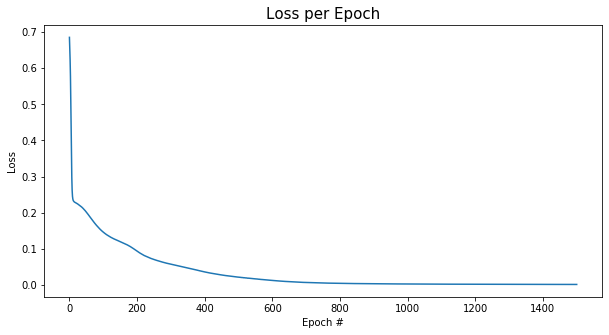

In [139]:
plot_loss(err)

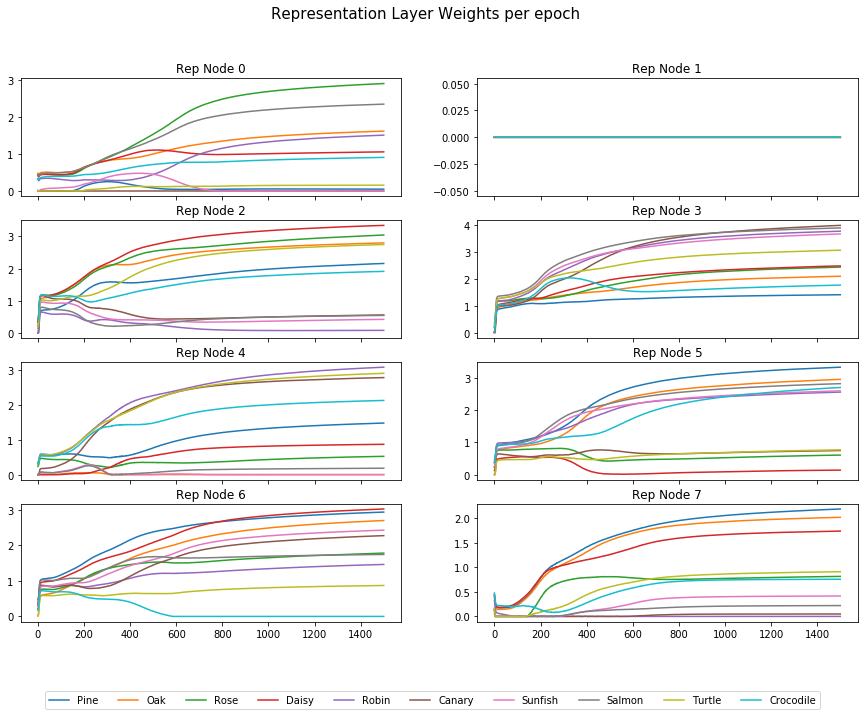

In [140]:
plot_rep(plot_option=1,rep_layer=rep_layer) # There are 3 plot options I created.

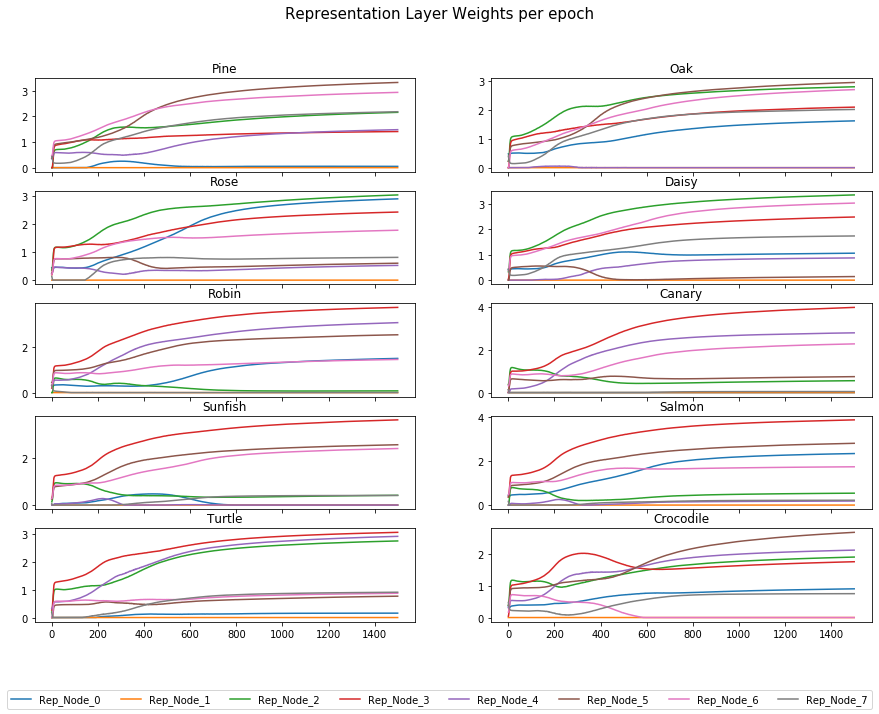

In [141]:
plot_rep(plot_option=2,rep_layer=rep_layer) # There are 3 plot options I created.

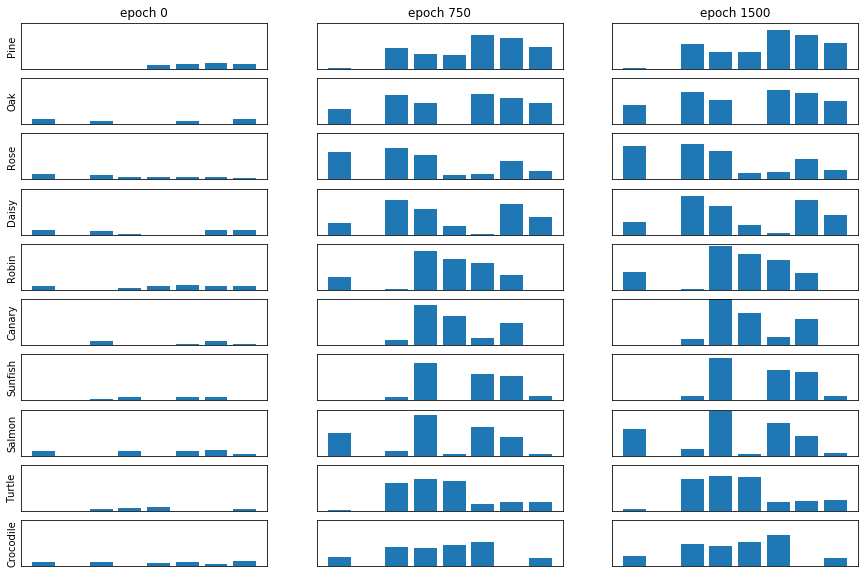

In [142]:
plot_rep(plot_option=3,rep_layer=rep_layer) # There are 3 plot options I created.

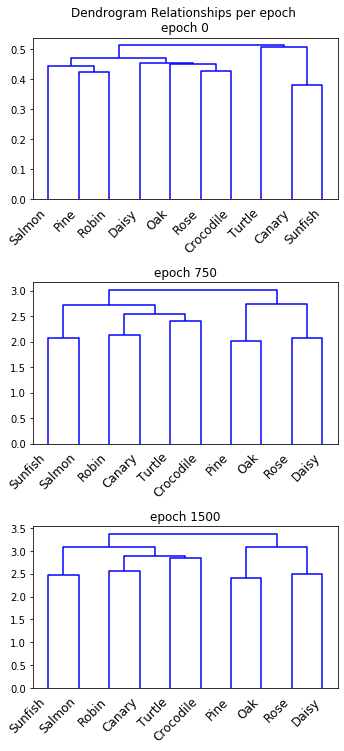

In [143]:
plot_dendo(rep_layer)

In [144]:
torch.save({'epoch' : n_epochs,
            'model_state_dict' : mynet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss' : err[-1]}, 'trained_model.pt')